In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import datetime
import pandas_datareader.data as web

%matplotlib inline

In [5]:
start = datetime.datetime(1970, 1, 1)
end = datetime.datetime(2020, 1, 27)

In [6]:
spx = web.DataReader('^GSPC', 'yahoo', start, end).dropna()

In [74]:
spx.shape

(12630, 6)

In [17]:
rets = spx.pct_change().dropna()['Close']

In [8]:
def sharpe_ratio(rets):
    return rets.mean() / rets.std()

In [9]:
def positions(x, theta):
    M = len(theta) - 2
    T = len(x)
    Ft = np.zeros(T)
    for t in range(M, T):
        xt = np.concatenate([[1], x[t - M:t], [Ft[t - 1]]])
        Ft[t] = np.tanh(np.dot(theta, xt))
    return Ft

In [10]:
def returns(Ft, x, delta):
    T = len(x)
    rets = Ft[0:T - 1] * x[1:T] - delta * np.abs(Ft[1:T] - Ft[0:T - 1])
    return np.concatenate([[0], rets])

In [11]:
def gradient(x, theta, delta):
    Ft = positions(x, theta)
    R = returns(Ft, x, delta)
    T = len(x)
    M = len(theta) - 2
    
    A = np.mean(R)
    B = np.mean(np.square(R))
    S = A / np.sqrt(B - A ** 2)

    dSdA = S * (1 + S ** 2) / A
    dSdB = -S ** 3 / 2 / A ** 2
    dAdR = 1. / T
    dBdR = 2. / T * R
    
    grad = np.zeros(M + 2)  # initialize gradient
    dFpdtheta = np.zeros(M + 2)  # for storing previous dFdtheta
    
    for t in range(M, T):
        xt = np.concatenate([[1], x[t - M:t], [Ft[t-1]]])
        dRdF = -delta * np.sign(Ft[t] - Ft[t-1])
        dRdFp = x[t] + delta * np.sign(Ft[t] - Ft[t-1])
        dFdtheta = (1 - Ft[t] ** 2) * (xt + theta[-1] * dFpdtheta)
        dSdtheta = (dSdA * dAdR + dSdB * dBdR[t]) * (dRdF * dFdtheta + dRdFp * dFpdtheta)
        grad = grad + dSdtheta
        dFpdtheta = dFdtheta

        
    return grad, S

In [59]:
def train(x, epochs=5000, M=8, commission=0.0025, learning_rate = 0.3):
    theta = np.random.rand(M + 2)
    sharpes = np.zeros(epochs) # store sharpes over time
    for i in range(epochs):
        grad, sharpe = gradient(x, theta, commission)
        theta = theta + grad * learning_rate

        sharpes[i] = sharpe
    
    
    print("finished training")
    return theta, sharpes

In [22]:
x = np.array(rets)

N = 1000
P = 200
x_train = x[-(N+P):-P]
x_test = x[-P:]

std = np.std(x_train)
mean = np.mean(x_train)

x_train = (x_train - mean) / std
x_test = (x_test - mean) / std

In [67]:
np.random.seed(0)
theta, sharpes = train(x_train, epochs=5000, M=25, commission=0, learning_rate=0.2)

finished training


In [68]:
theta

array([ 0.38593998,  2.37481951,  2.46617669,  1.33052583,  1.50193036,
        0.83343774,  1.37413973,  1.65416876,  3.59676002,  0.17653288,
        1.81244425,  1.62899597,  0.17082931, -0.41468151,  0.09928751,
        0.3844142 ,  0.15468366,  2.35592802,  2.78536563, -0.15718833,
        0.53018161,  3.02591175,  2.06256034, -0.47594908,  0.44476112,
        0.50344234,  2.18673918])

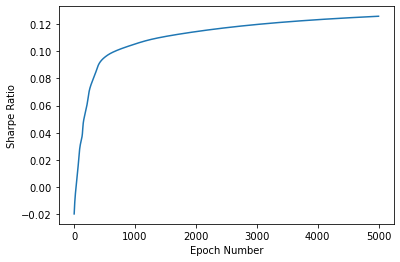

In [69]:
plt.plot(sharpes)
plt.xlabel('Epoch Number')
plt.ylabel('Sharpe Ratio');

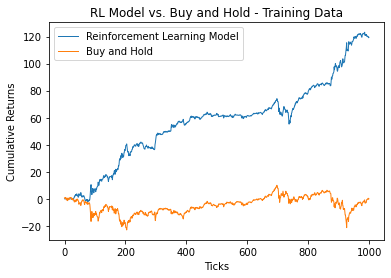

In [79]:
train_returns = returns(positions(x_train, theta), x_train, 0)
plt.plot((train_returns).cumsum(), label="Reinforcement Learning Model", linewidth=1)
plt.plot(x_train.cumsum(), label="Buy and Hold", linewidth=1)
plt.xlabel('Ticks')
plt.ylabel('Cumulative Returns');
plt.legend()
plt.title("RL Model vs. Buy and Hold - Training Data");

(array([  6.,  11.,  41., 120., 565., 205.,  43.,   6.,   2.,   1.]),
 array([-4.80434494, -3.75165494, -2.69896495, -1.64627495, -0.59358496,
         0.45910504,  1.51179503,  2.56448503,  3.61717503,  4.66986502,
         5.72255502]),
 <a list of 10 Patch objects>)

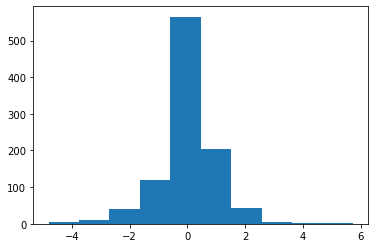

In [83]:
plt.hist(x_train)

In [85]:
train_returns = returns(positions(x_train, theta), (x_train*std + mean), 0)

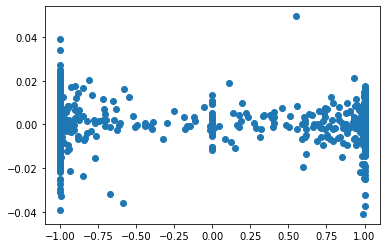

In [90]:
plt.scatter(positions(x_train, theta),(x_train*std + mean))

In [92]:
theta.shape

(27,)

In [88]:
train_returns.std()

0.008168524026168552

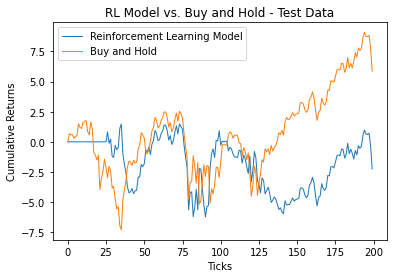

In [71]:
test_returns = returns(positions(x_test, theta), x_test, 0.0025)
plt.plot((test_returns).cumsum(), label="Reinforcement Learning Model", linewidth=1)
plt.plot(x_test.cumsum(), label="Buy and Hold", linewidth=1)
plt.xlabel('Ticks')
plt.ylabel('Cumulative Returns');
plt.legend()
plt.title("RL Model vs. Buy and Hold - Test Data");

In [98]:
test_returns

array([ 0.00000000e+00,  0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
       -0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00, -0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
        0.00000000e+00, -0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00, -2.49982899e-03,  8.25902849e-01, -9.45999296e-01,
        3.53878066e-01, -1.41976405e+00, -1.12910261e-01,  1.01139970e+00,
       -3.64440045e-01,  1.95370741e-01,  1.57219062e+00,  3.62900625e-01,
       -2.44948187e+00, -9.07107852e-01, -6.71603587e-01, -1.17858894e+00,
       -5.00107765e-01,  8.21522775e-02,  2.75942391e-01, -4.26619598e-01,
        2.23942311e-01,  6.30361410e-02,  1.08539215e+00, -3.66903952e-03,
        1.05583371e+00, -1.92861766e-01,  2.42712869e-01,  1.14079441e+00,
       -1.43992541e-01,  

In [96]:
test_returns.mean()/test_returns.std()

-0.013918700760269805

In [100]:
rets.shape[0]

12629

In [ ]:


x = np.array(rets)

N = 1000
P = 200
x_train = x[-(N+P):-P]
x_test = x[-P:]

std = np.std(x_train)
mean = np.mean(x_train)

x_train = (x_train - mean) / std
x_test = (x_test - mean) / std

theta, sharpes = train(x_train, epochs=2000, M=25, commission=0, learning_rate=0.2)
test_returns = returns(positions(x_test, theta), x_test, 0)


finished training
finished training
finished training
finished training
finished training
finished training
finished training
finished training
finished training
finished training
finished training
finished training
finished training
finished training
finished training
finished training
finished training
finished training
finished training
finished training
finished training
finished training
finished training
finished training
finished training
finished training
finished training
finished training
finished training
finished training
finished training
finished training
finished training
finished training
finished training
finished training
finished training
finished training
finished training
finished training
finished training
finished training


C:\Users\mattk\anaconda3\lib\site-packages\numpy\core\_methods.py:216: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\mattk\anaconda3\lib\site-packages\numpy\core\_methods.py:185: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
C:\Users\mattk\anaconda3\lib\site-packages\numpy\core\_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\mattk\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\mattk\anaconda3\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-11-805f5faae33f>:9: RuntimeWarning: invalid value encountered in double_scalars
  S = A / np.sqrt(B - A ** 2)


ZeroDivisionError: float division by zero

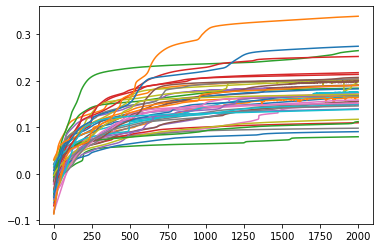

In [141]:
start = 100

all_rets = []

for i in range(50):

    N = 1000
    P = 200
    x_train = x[start:start+N]
    x_test = x[start+N:start+N+P]

    std = np.std(x_train)
    mean = np.mean(x_train)

    x_train = (x_train - mean) / std
    x_test = (x_test - mean) / std

    theta, sharpes = train(x_train, epochs=2000, M=25, commission=0, learning_rate=0.2)
    plt.plot(sharpes)
    test_returns = returns(positions(x_test, theta), x_test, 0)

    test_returns = test_returns*std+mean

    all_rets.append(test_returns)
    start+=300


In [142]:
np.array(all_rets).shape

(42,)

In [143]:
out = np.concatenate(all_rets)

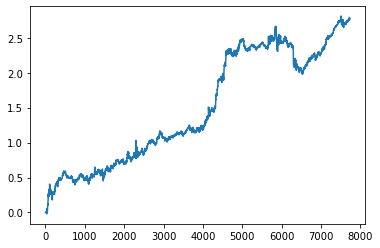

In [144]:
plt.plot(out.cumsum())

In [145]:
out.mean()*np.sqrt(252)/out.std()

0.6116833561840477

(array([1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 2.000e+00, 0.000e+00,
        5.000e+00, 7.000e+00, 1.500e+01, 2.400e+01, 4.300e+01, 7.900e+01,
        2.540e+02, 6.010e+02, 1.563e+03, 3.485e+03, 9.770e+02, 4.000e+02,
        1.540e+02, 6.800e+01, 2.700e+01, 1.200e+01, 7.000e+00, 2.000e+00,
        1.000e+00, 0.000e+00, 2.000e+00, 1.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00]),
 array([-0.08985712, -0.08394387, -0.07803061, -0.07211735, -0.06620409,
        -0.06029084, -0.05437758, -0.04846432, -0.04255107, -0.03663781,
        -0.03072455, -0.02481129, -0.01889804, -0.01298478, -0.00707152,
        -0.00115827,  0.00475499,  0.01066825,  0.01658151,  0.02249476,
         0.02840802,  0.03432128,  0.04023454,  0.04614779,  0.05206105,
         0.

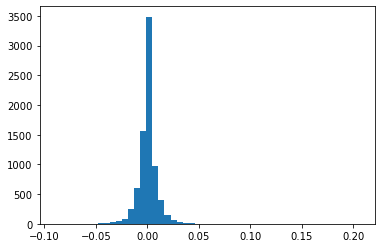

In [146]:
plt.hist(out,bins=50)

In [140]:
rets[100:2100].mean()*np.sqrt(252)/rets[100:2100].std()

0.37321378867787186